<a href="https://colab.research.google.com/github/gommungommun/remind_data/blob/master/DataLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
!git clone https://github.com/gommungommun/remind_data.git

Cloning into 'remind_data'...
remote: Enumerating objects: 8, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 8 (delta 0), reused 8 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (8/8), done.


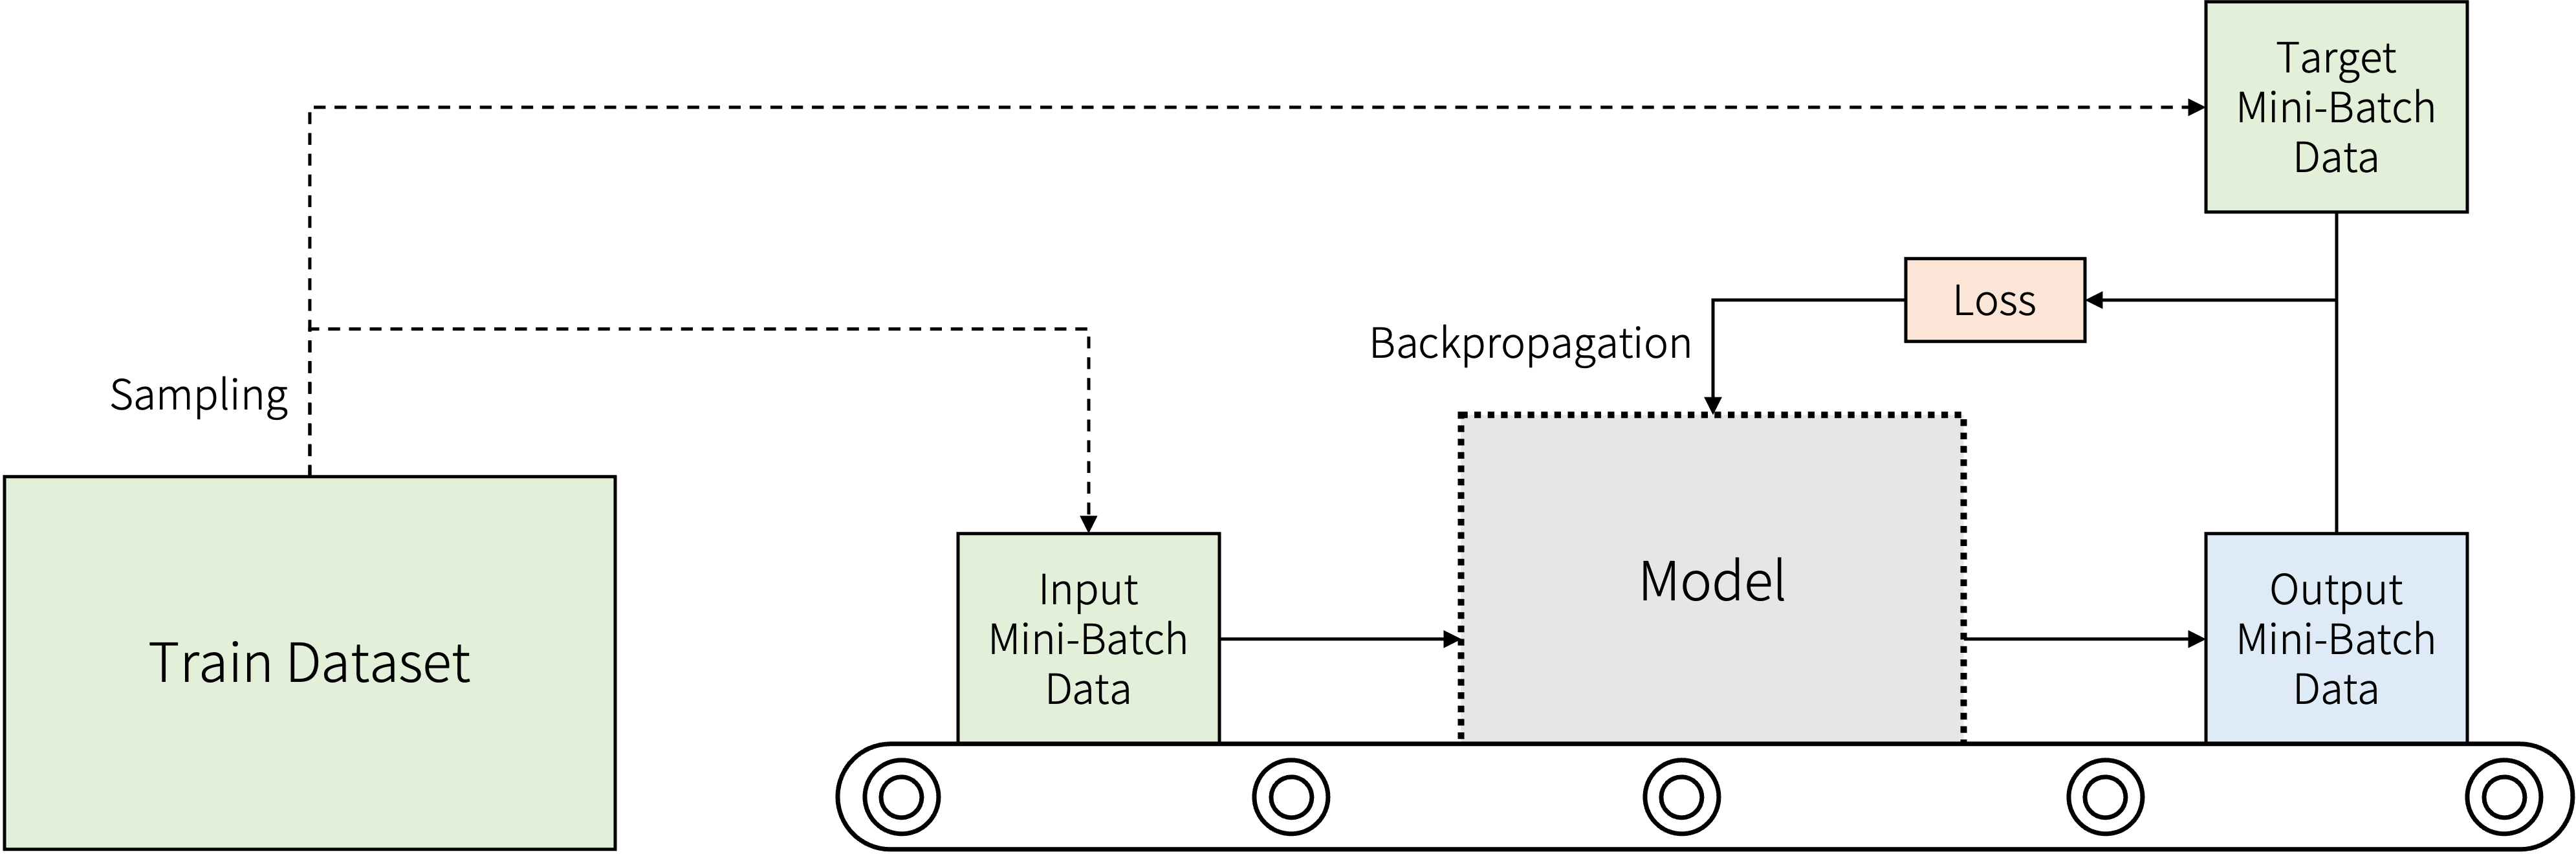

여기서 학습할 데이터 셋을 쪼개서 미니 배치 단위로 모델에 입력하게 된다.

이것을 도와주는 것이 DataLoader가 된다.

In [1]:
from torch.utils.data import Dataset, DataLoader

##파라미터
DataLoader(dataset, batch_size=1, shuffle=False, ...)

dataset만 넘겨주어도 DataLoader 인스턴스가 생성될 수 있다.

보통은,

dataloader = DataLoader(dataset, batch_size=16, shuffle=True)를 이용해 생성한다.

---
PyTorch는
1. torch.utils.data.DataLoader
: Dataset을 sample에 쉽게 접근할 수 있도록 iterables한 객체로 감싼다.
2. torch.utils.data.Dataset
: sample과 label(정답)을 제공한다

 두 가지 데이터 기본 요소를 제공하여 미리 준비해둔 dataset뿐만 아니라 가지고 있는 데이터를 사용할 수 있도록 한다.

---
##Dataset 불러오기

* root: 학습/테스트 데이터가 저장되는 경로
* train: 학습/테스트 용 dataset여부를 저장함
* download=True: root에 데이터가 없는 경우 인터넷에서 다운로드
* transform과 target_transform은 feature, label, transform을 지정함

In [4]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:03<00:00, 8.58MB/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 135kB/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.57MB/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 11.1MB/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



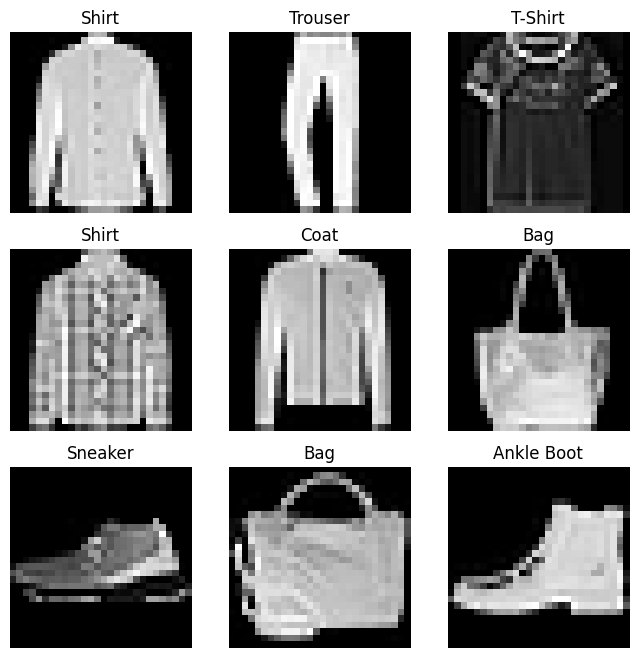

In [6]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item()
  img, label = training_data[sample_idx]
  figure.add_subplot(rows,cols,i)
  plt.title(labels_map[label])
  plt.axis("off")
  plt.imshow(img.squeeze(), cmap="gray")
plt.show()

##사용자 정의 dataset 만들기

###1. init
* 객체가 생성될 때 한 번만 실행

###2. len
* 데이터셋의 샘플 개수를 반환

###3. getitem
* 주어진 인덱스에 해당하는 sample을 dataset에서 불러오고 반환
* 인덱스를 기반으로 디스크에서 이미지의 위치를 식별하고
* read_image를 사용하여 이미지를 텐서로 변환하고
* self.img_labels의 cvs데이터로부터 해당하는 label을 가져오고 해당하는 경우 transform함수들을 호출 한 후
* tensor image와 label을 dict형으로 return

In [7]:
import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
    image = read_image(img_path)
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)

    return image, label

##DateLoader로 학습용 데이터 준비하기

* Dataset은 특정 feature를 가져오고 하나의 샘플에 label을 정하는 일을 한번에 함.

* 모델 학습시 샘플들은 미니배치로 전달되고 epoch마다 data를 섞어서 overfitting을 방지함

In [8]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


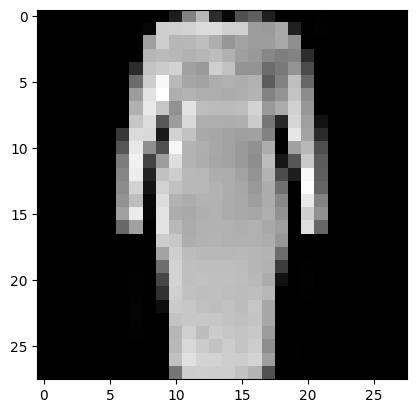

Label: 3


In [9]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")